This notebook gathers results from running top-pruning and generalized pruning nni-searches on the ds-datasets.

To benchmark against existing methods, we compare with the topologies discovered by a short run of Mr Bayes and match the data by the number of likelihood calculations. Soon we will also match the data by approximate run-time.

In [108]:
%%javascript
 
// I dislike the default Jupyter notebook scrolling.
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [110]:
# Load all data files into dataframes.

ds_datasets = [1, 3, 4, 5, 6, 7, 8]
mb_prior = {"uniform":"_output", "exponential":"_exp_output"}
search_type = {"top-pruning": "tp", "generalized-pruning": "gp"}
iter_count = 500

search_results_path = "data/ds{}/{}/ds{}.results.{}.{}.csv"
found_trees_stats_path = "data/ds{}/{}/ds{}.found-trees-dag-stats.{}.{}.csv"
short_mcmc_stats_path = "data/ds{}/{}/short_mcmc/mcmc_search_sdag_stats.csv"

ds_search_results_dataframes = {}
ds_short_mcmc_dataframes = {}
for ds in ds_datasets:
    for prior, prior_path in mb_prior.items():
        for search, search_path in search_type.items():
            results_path = search_results_path.format(
                ds, prior_path, ds, search_path, iter_count
            )
            results_df = pd.read_csv(results_path)
            results_df.drop_duplicates(subset="iter", keep="first", inplace=True)
            for posterior_type in ["credible", "posterior"]:
                extra_stats_path = found_trees_stats_path.format(
                    ds, prior_path, ds, search_path, posterior_type
                )
                extra_stats_df = pd.read_csv(extra_stats_path)
                column_rename_dict = {
                    column: f"{posterior_type}_sdag_{column}"
                    for column in ["tree_count", "node_count", "edge_count"]
                }
                extra_stats_df.rename(columns=column_rename_dict, inplace=True)
                results_df = results_df.merge(extra_stats_df, on="iter")                
            ds_search_results_dataframes[(ds, prior, search)] = results_df
        short_mcmc_path = short_mcmc_stats_path.format(ds,prior_path)
        short_mcmc_df = pd.read_csv(short_mcmc_path)
        ds_short_mcmc_dataframes[(ds, prior)] = short_mcmc_df

In [4]:
def plot_search_results(
    ds, 
    prior, 
    search, 
    max_iter=None, 
    stop_at_max_posterior=True, 
    stop_at_credible=False
):
    """
    Create plots for the specified type of nni-search on the given dataset using 
    the given Mr Bayes emperical posterior.

    Parameters:
        ds (int): The dataset number. This should be 1, 3, 4, 5, 6, 7, or 8.
        prior (str): The branch length prior for the Mr. Bayes posterior. This should be 
        "uniform" or "exponential".
        search (str): The search type. This should be "top-pruning" or 
            "generalized-pruning".
        max_iter (int): Optional cut-off for the search iteration.
        stop_at_max_posterior (bool): Optionally cut-off the search iteration to that of 
            the last found topology in the Mr. Bayes credible set. 
        stop_at_credible (bool): Optionally cut-off the search iteration to the of the 
            last found found topology in the Mr. Bayes posterior.

    """
    search_df = ds_search_results_dataframes[(ds, prior, search)]      
    mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
    if max_iter is not None:
        search_df = search_df[search_df.iter <= max_iter]
    if stop_at_max_posterior:
        last_posterior_tree_iteration = search_df.tree_pp.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]
    if stop_at_credible:
        last_credible_tree_iteration = search_df.cred_tree_count.argmax()
        search_df = search_df[search_df.iter <= last_posterior_tree_iteration]

    dag_label = f"{search} sDAG"
    cred_subdag_label = "sub-sDAG spanned by found credible trees"
    posterior_subdag_label = "sub-sDAG spanned by found posterior trees"
    iter_label = f"{search} iteration"
    fig_title = f"{search} search of DS{ds} Mr. Bayes posterior w/ {prior} branch length prior"
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(5*fig.get_figheight())
    
    options = {"s":10, "alpha":0.75}
    
    ax1.scatter(search_df.iter, search_df.tree_pp, **options)
    ax1.set_xlabel(iter_label)
    ax1.set_ylabel("cumulative density of trees\n in search sDAG")

    ax2.scatter(search_df.llhs_computed, search_df.tree_pp, label=dag_label, **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.total_pp, label="short run of Mr. Bayes", **options)
    ax2.scatter(mcmc_df.mcmc_iters, mcmc_df.sdag_total_pp, 
                label="sdag spanned by short run of Mr. Bayes", **options)
    ax2.set_xlabel("tree log-likelihood calculations")
    ax2.set_ylabel("cumulative density of trees")
    ax2.legend()
    
    ax3.scatter(search_df.iter, search_df.edge_count, label=dag_label, **options)
    ax3.scatter(search_df.iter, search_df.credible_sdag_edge_count, label=cred_subdag_label, **options)
    ax3.scatter(search_df.iter, search_df.posterior_sdag_edge_count, label=posterior_subdag_label, **options)
    ax3.set_xlabel(iter_label)
    ax3.set_ylabel("edges in sDAG")
    ax3.legend()
    
    ax4.scatter(search_df.iter, search_df.tree_count.apply(int), label=dag_label, **options)
    ax4.scatter(search_df.iter, search_df.credible_sdag_tree_count, 
        label=cred_subdag_label, **options)
    ax4.scatter(search_df.iter, search_df.posterior_sdag_tree_count, 
        label=posterior_subdag_label, **options)
    ax4.set_xlabel(iter_label)
    ax4.set_ylabel("topologies in sDAG")
    ax4.legend()
    ax4.ticklabel_format(useOffset=False, style="plain")

    
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(fig_title, va="bottom",y=0.9)
    fig.set_facecolor("white")
    
    plt.show()

## Top-pruning results

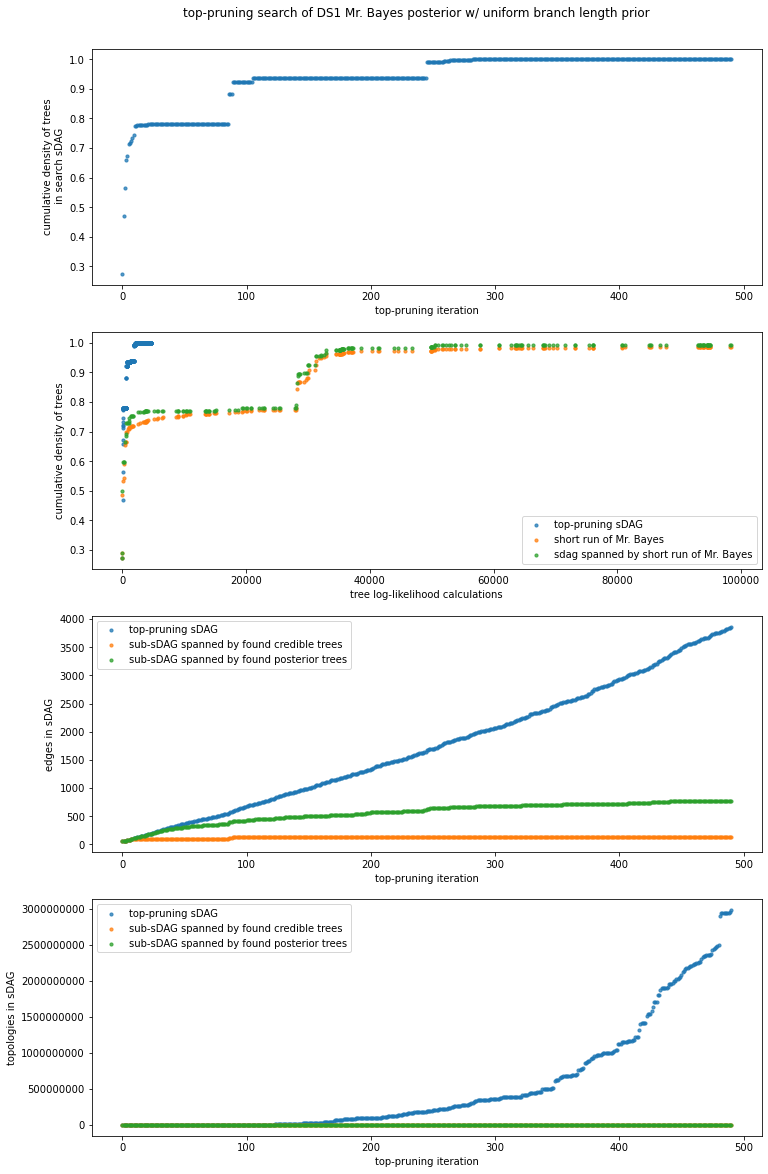

In [6]:
plot_search_results(1, "uniform", "top-pruning")

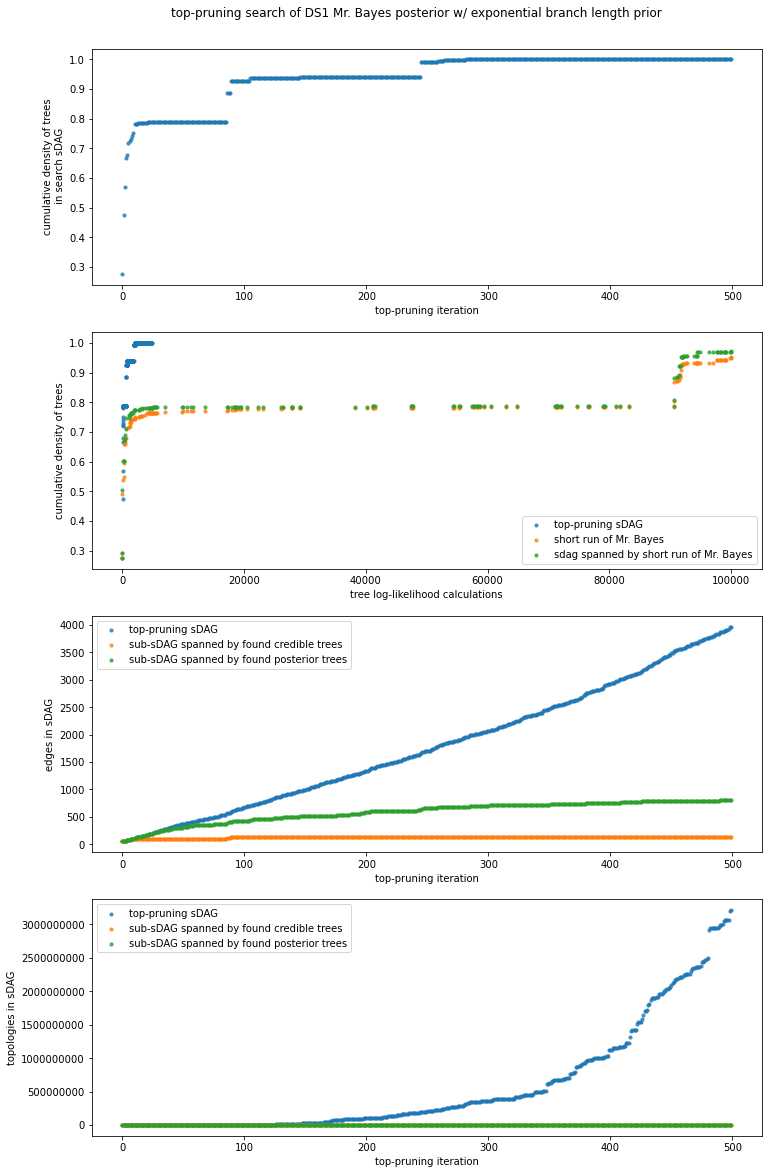

In [7]:
plot_search_results(1, "exponential", "top-pruning")

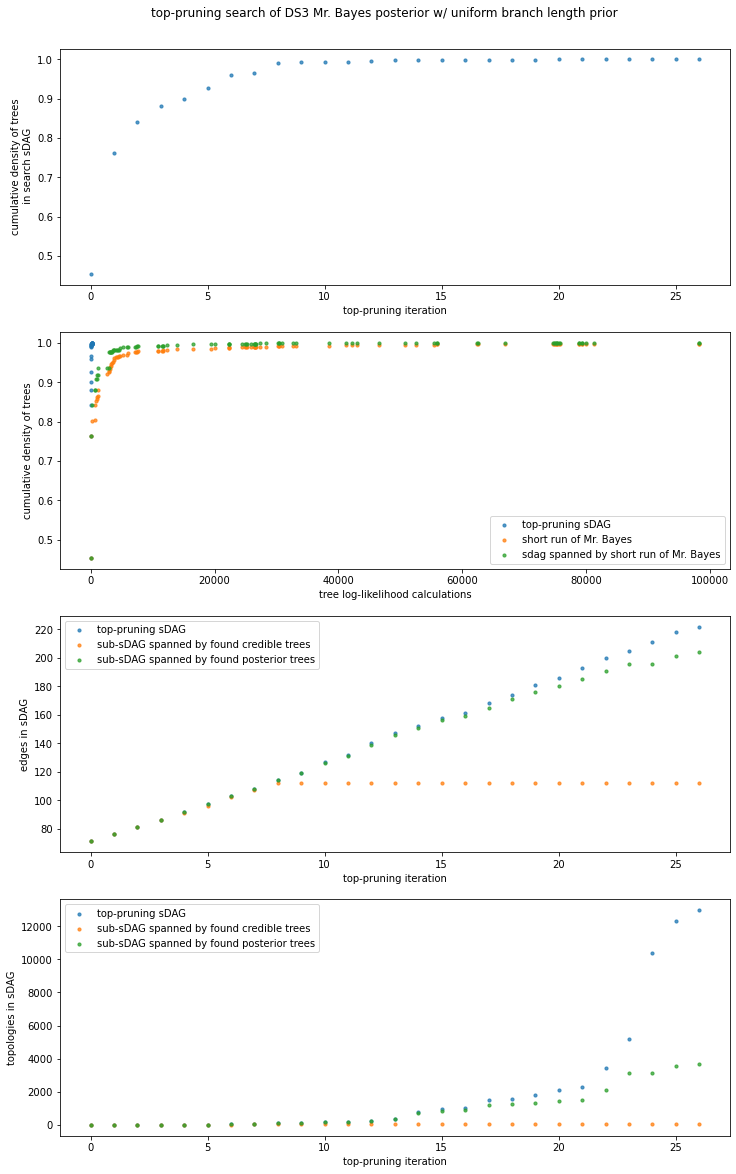

In [8]:
plot_search_results(3, "uniform", "top-pruning")

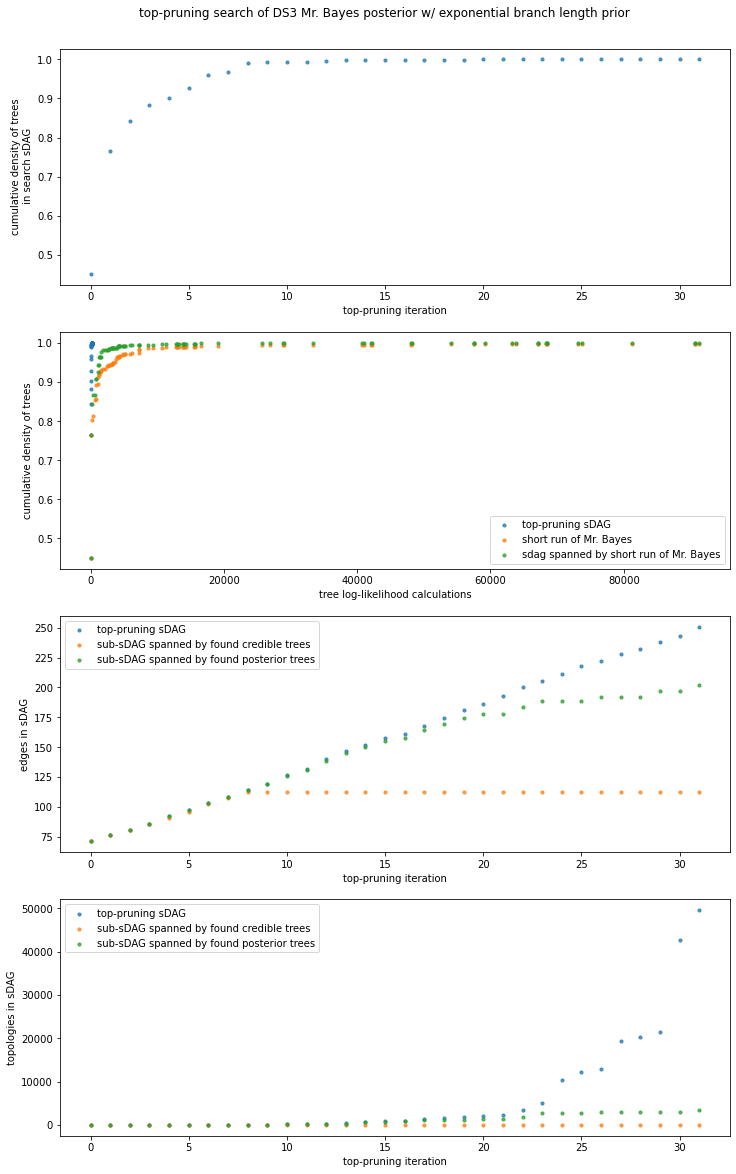

In [9]:
plot_search_results(3, "exponential", "top-pruning")

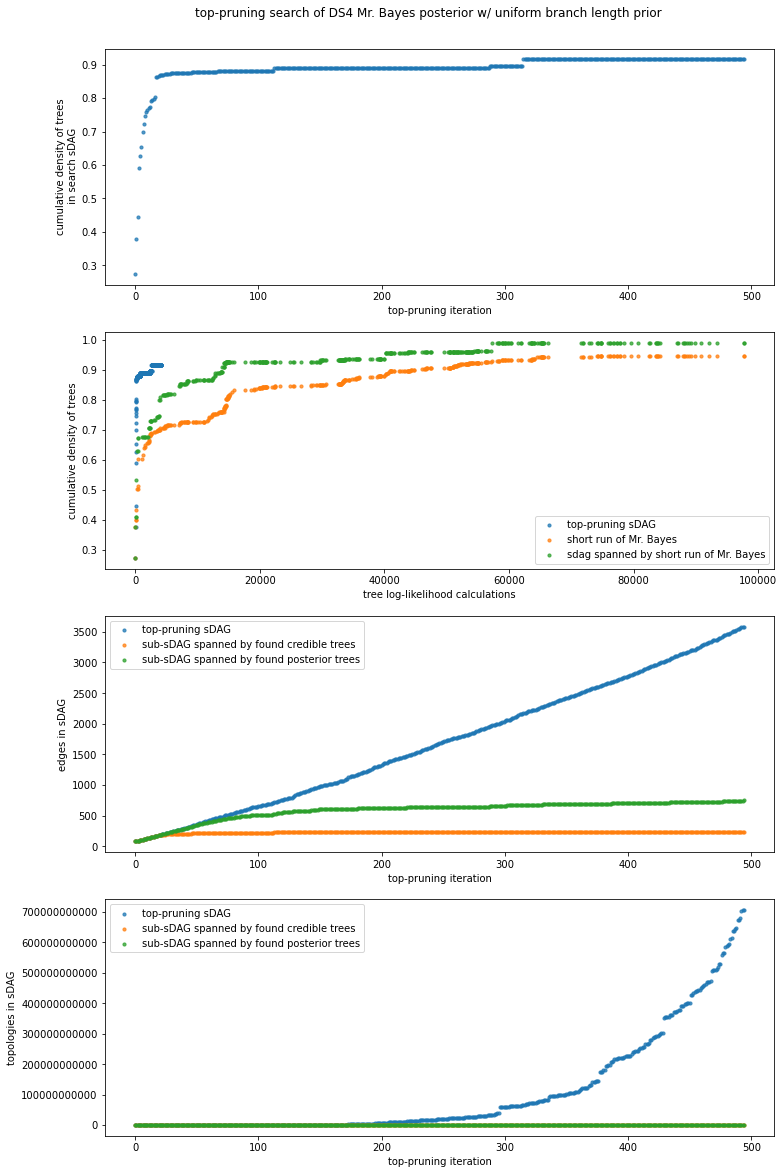

In [10]:
plot_search_results(4, "uniform", "top-pruning")

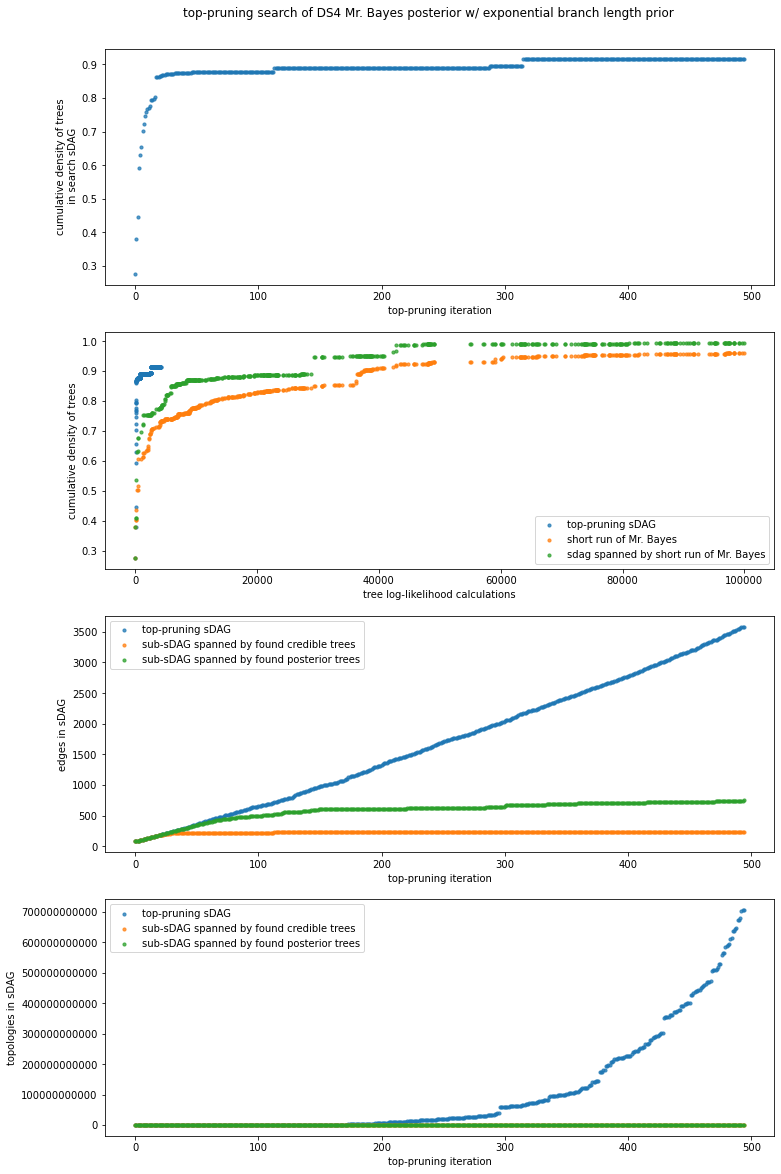

In [11]:
plot_search_results(4, "exponential", "top-pruning")

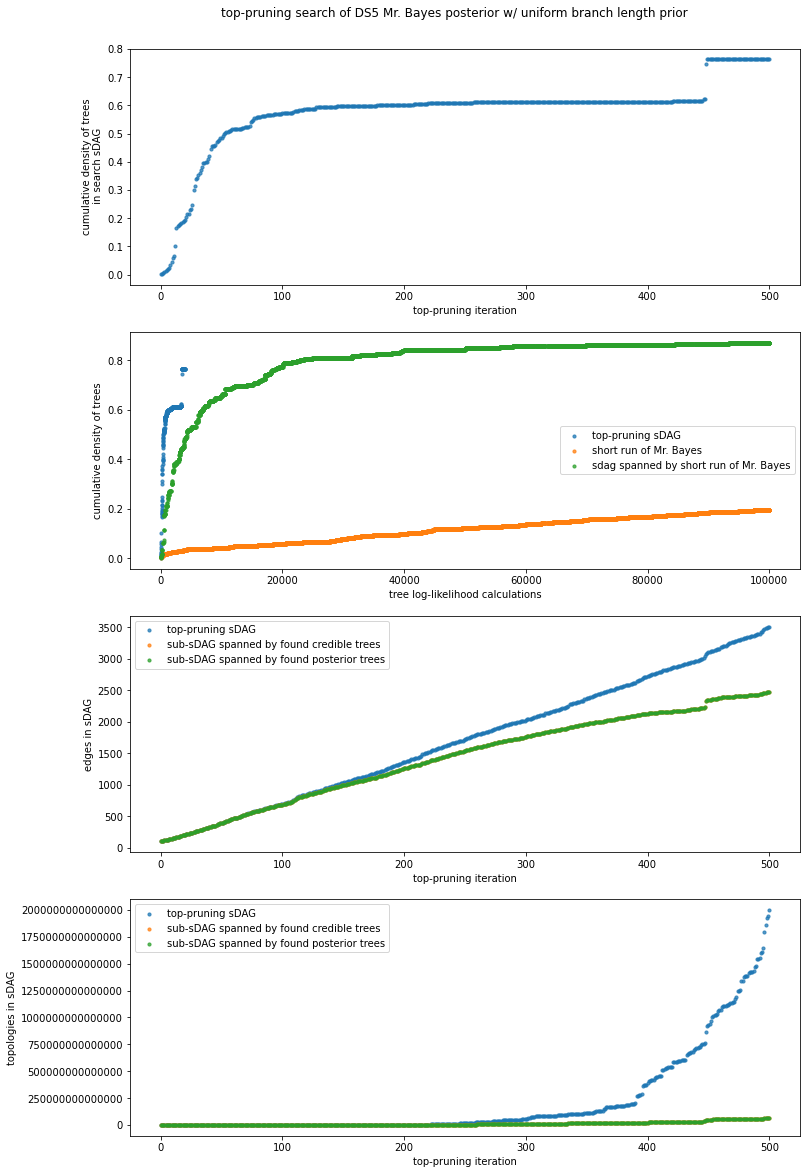

In [12]:
plot_search_results(5, "uniform", "top-pruning")

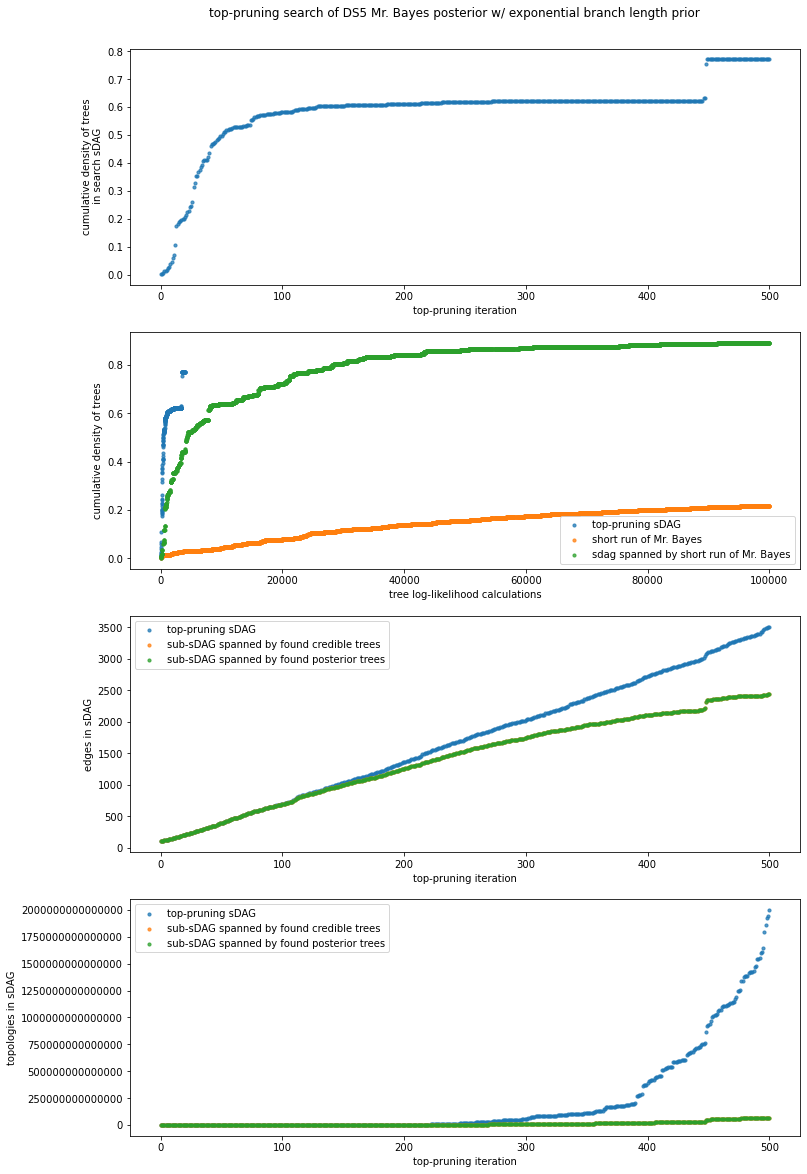

In [13]:
plot_search_results(5, "exponential", "top-pruning")

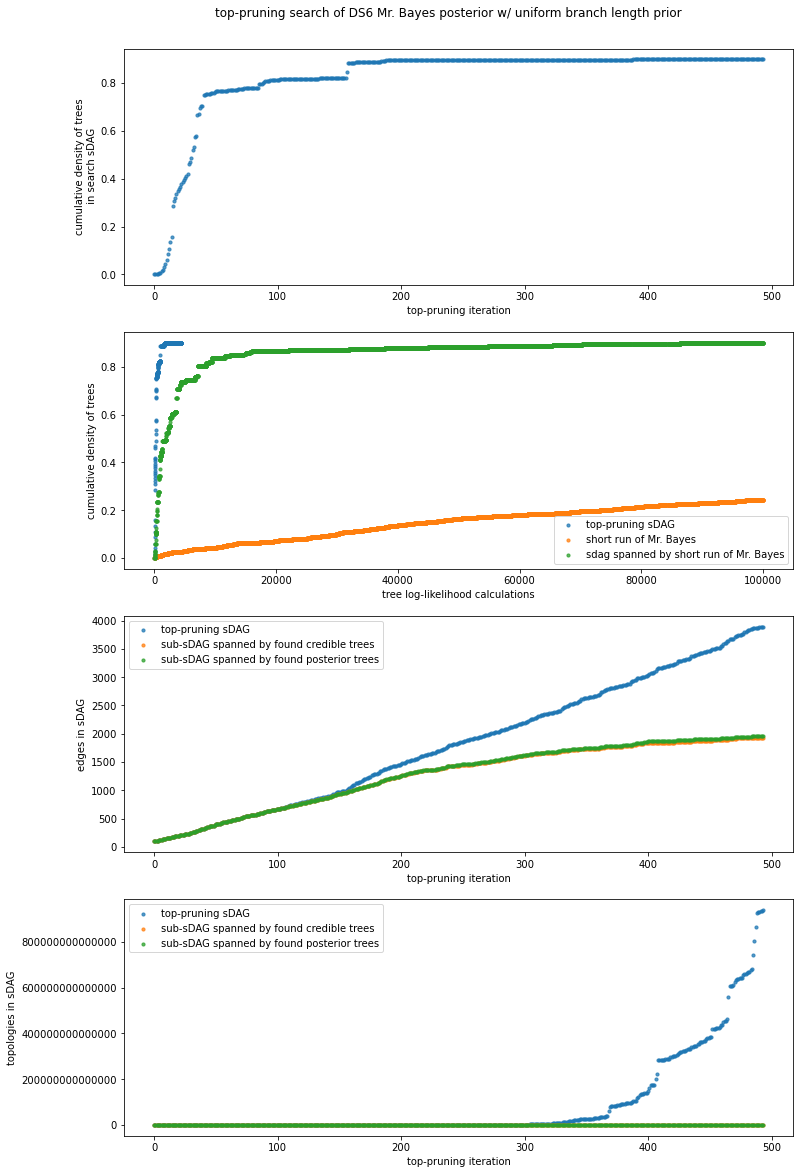

In [14]:
plot_search_results(6, "uniform", "top-pruning")

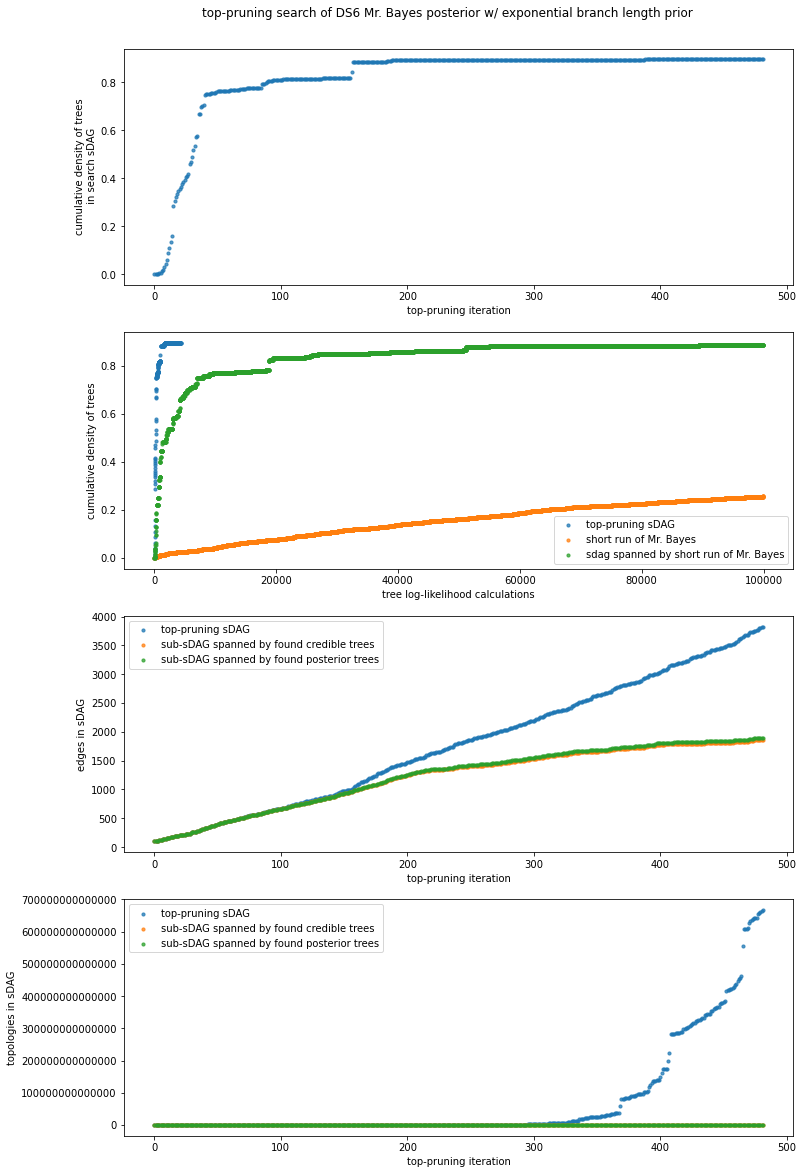

In [15]:
plot_search_results(6, "exponential", "top-pruning")

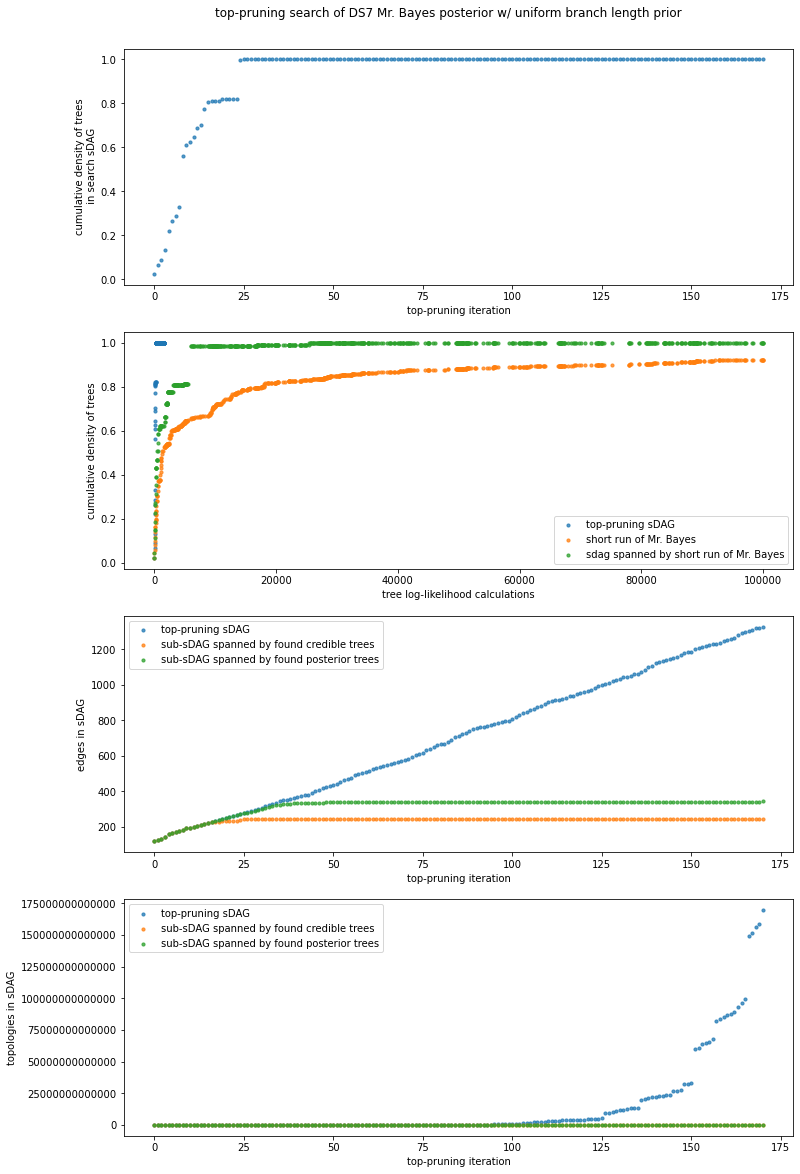

In [12]:
plot_search_results(7, "uniform", "top-pruning")

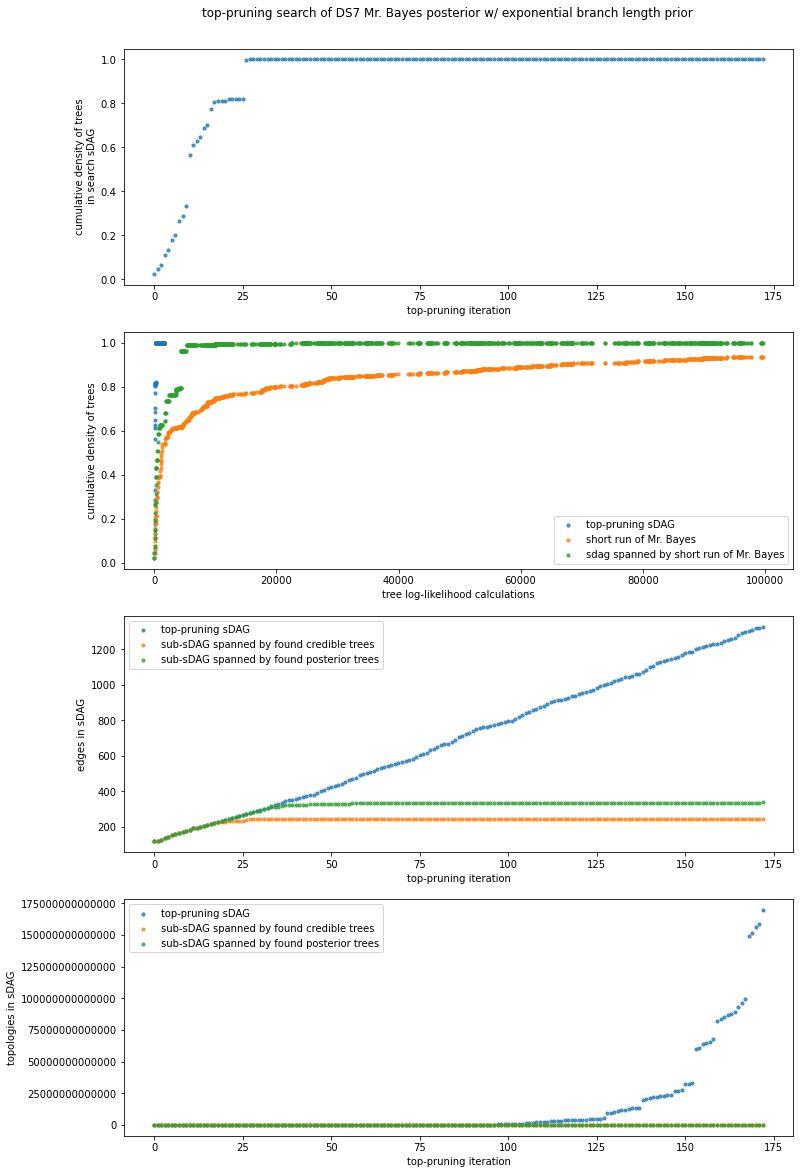

In [17]:
plot_search_results(7, "exponential", "top-pruning")

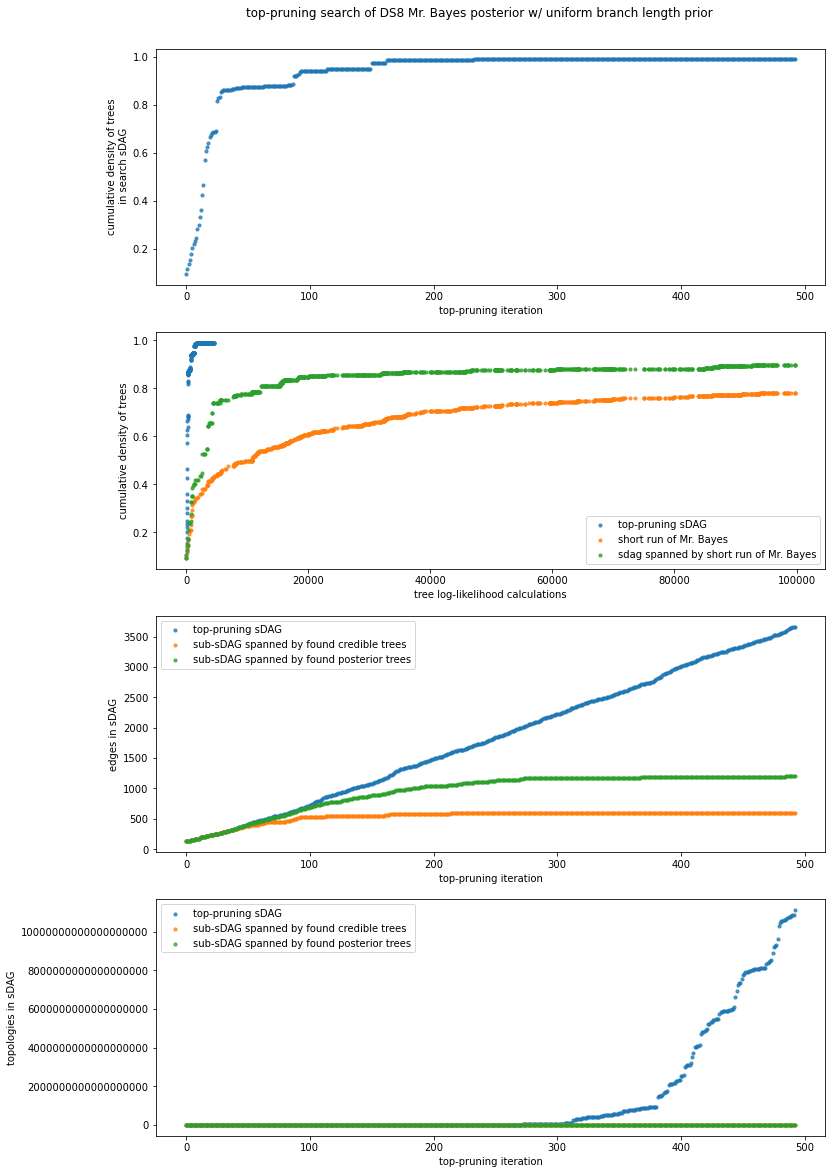

In [18]:
plot_search_results(8, "uniform", "top-pruning")

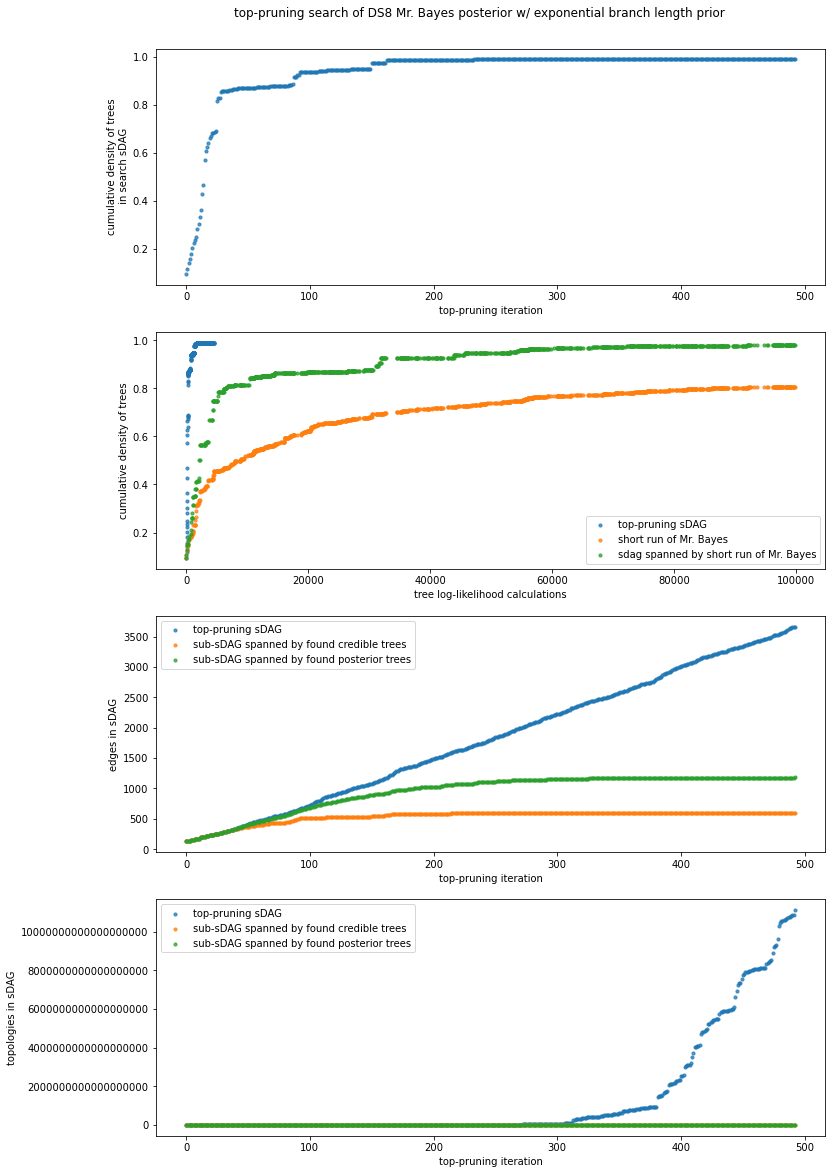

In [19]:
plot_search_results(8, "exponential", "top-pruning")

## Generalized-pruning results

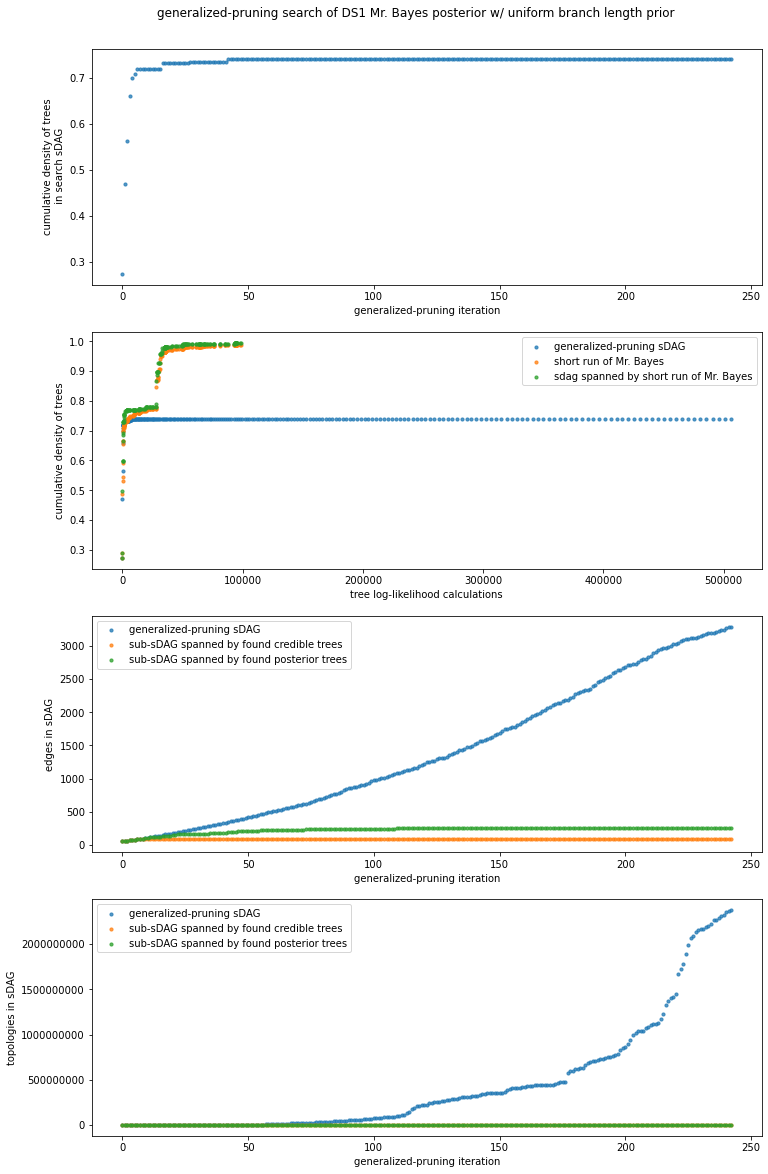

In [5]:
plot_search_results(1, "uniform", "generalized-pruning")

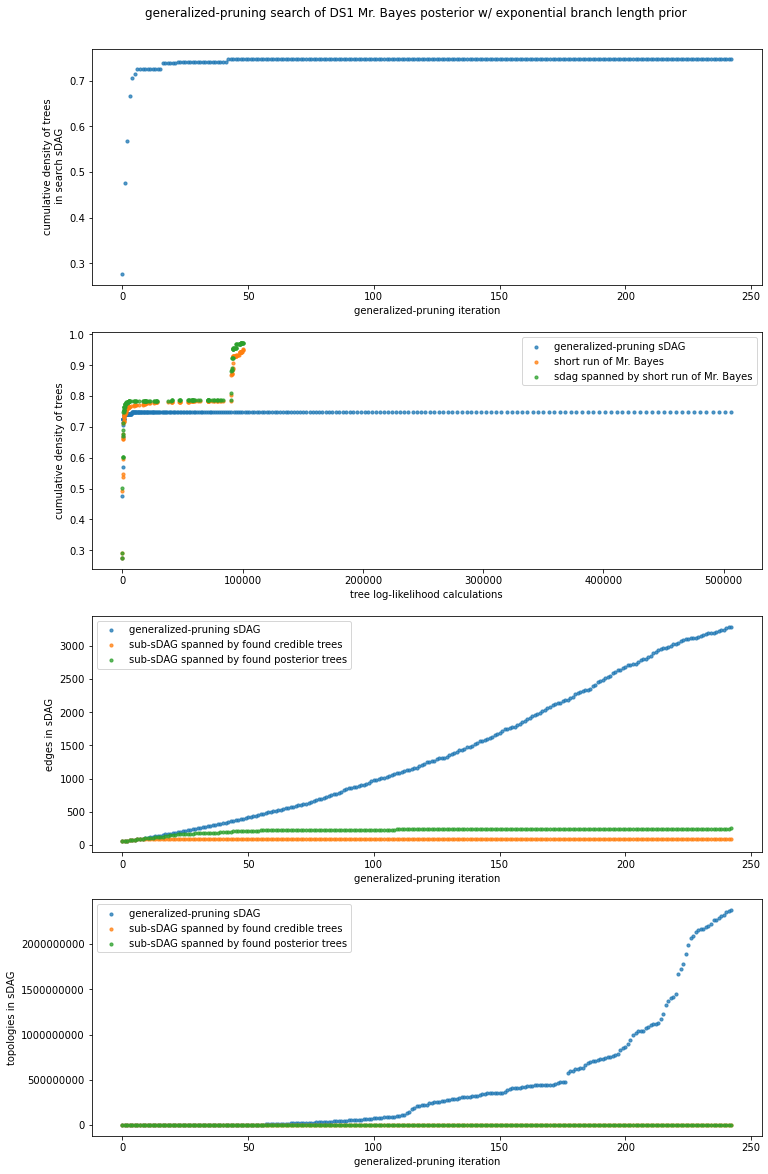

In [6]:
plot_search_results(1, "exponential", "generalized-pruning")

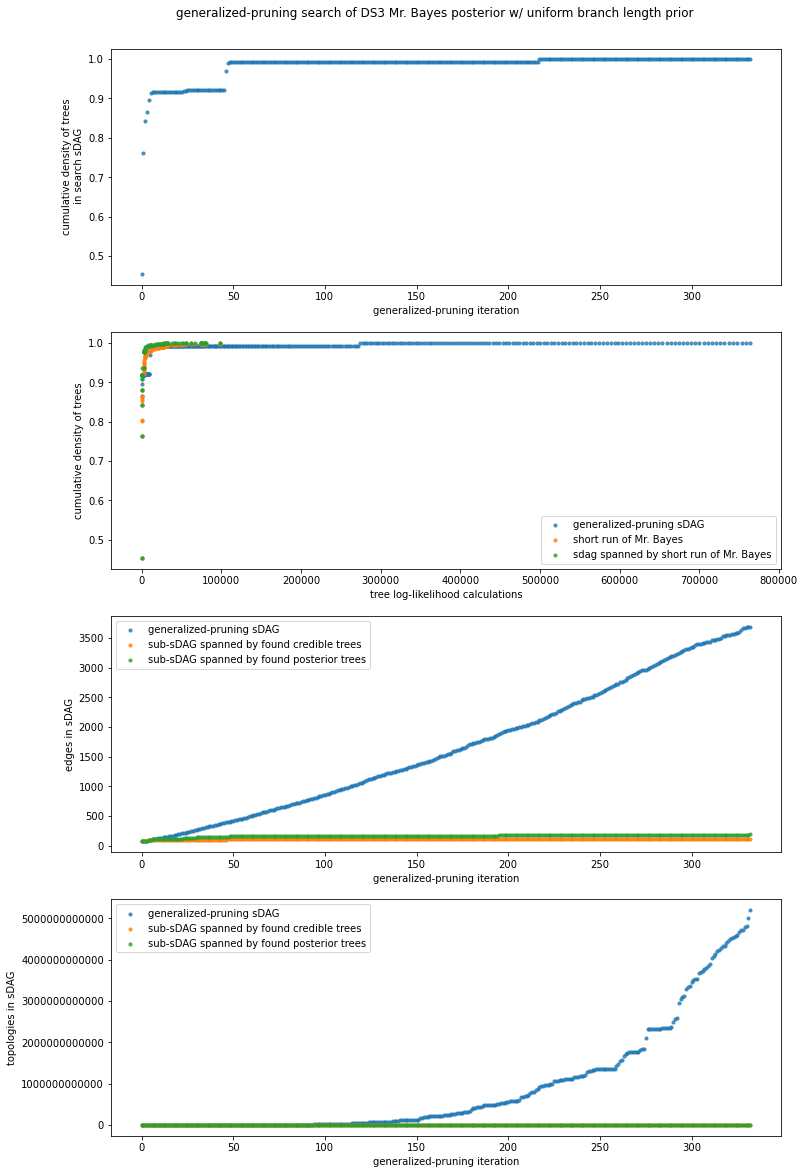

In [6]:
plot_search_results(3, "uniform", "generalized-pruning")

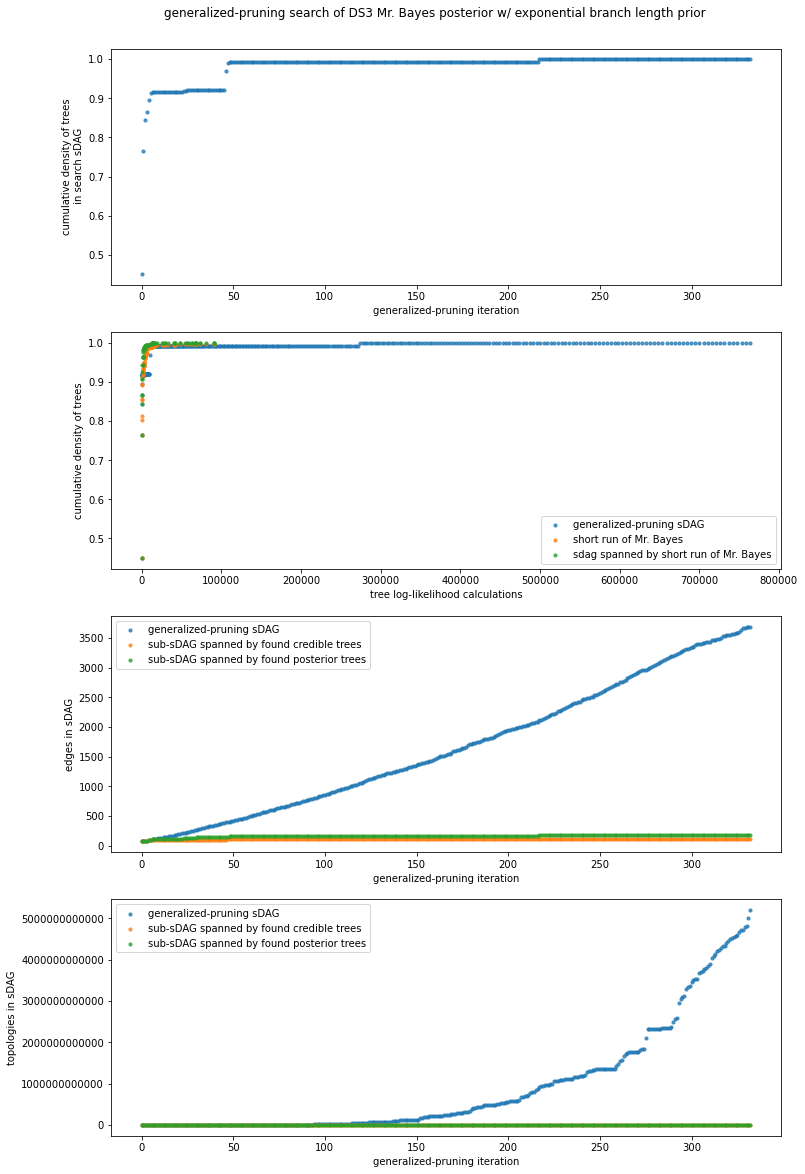

In [11]:
plot_search_results(3, "exponential", "generalized-pruning")

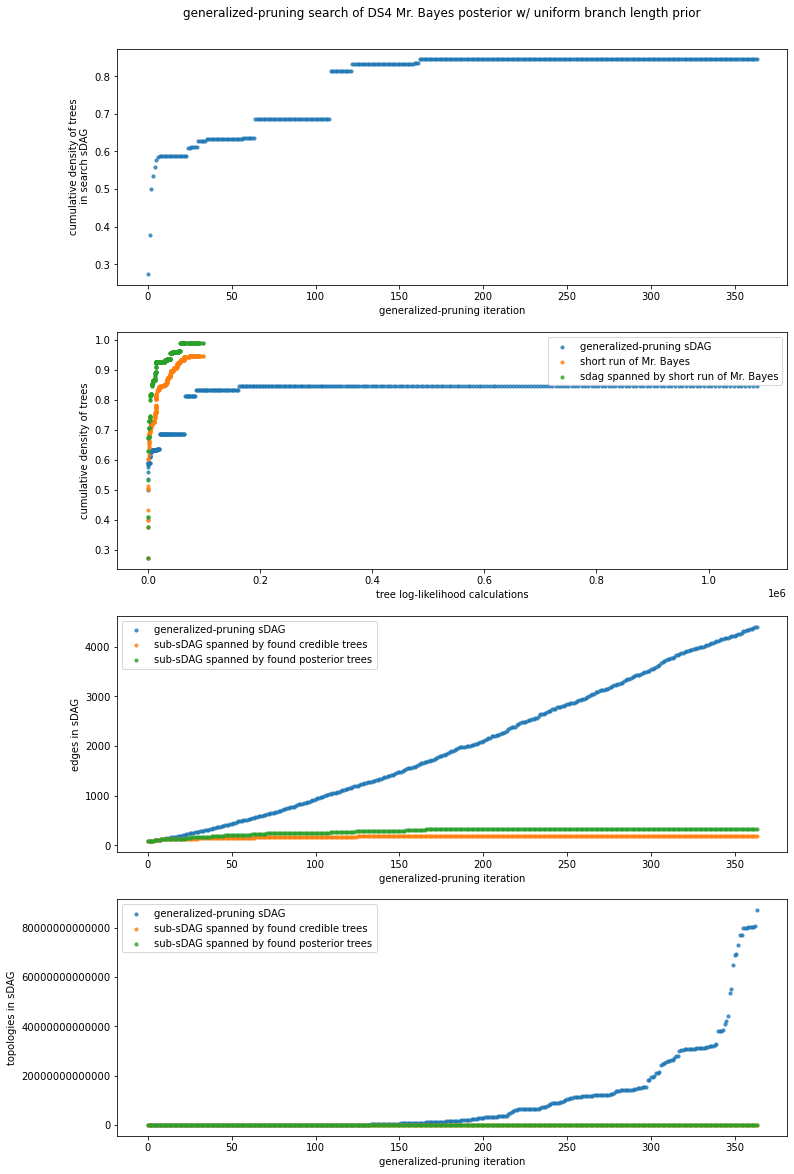

In [13]:
plot_search_results(4, "uniform", "generalized-pruning")

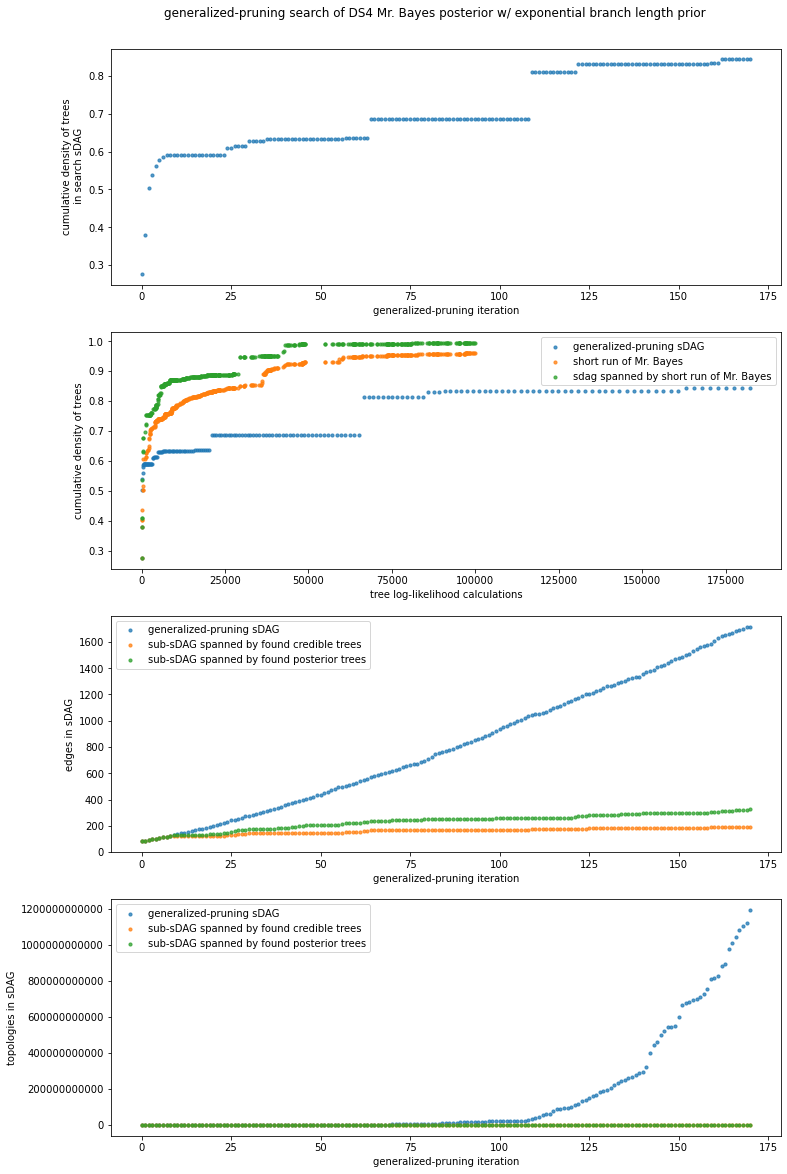

In [9]:
plot_search_results(4, "exponential", "generalized-pruning")

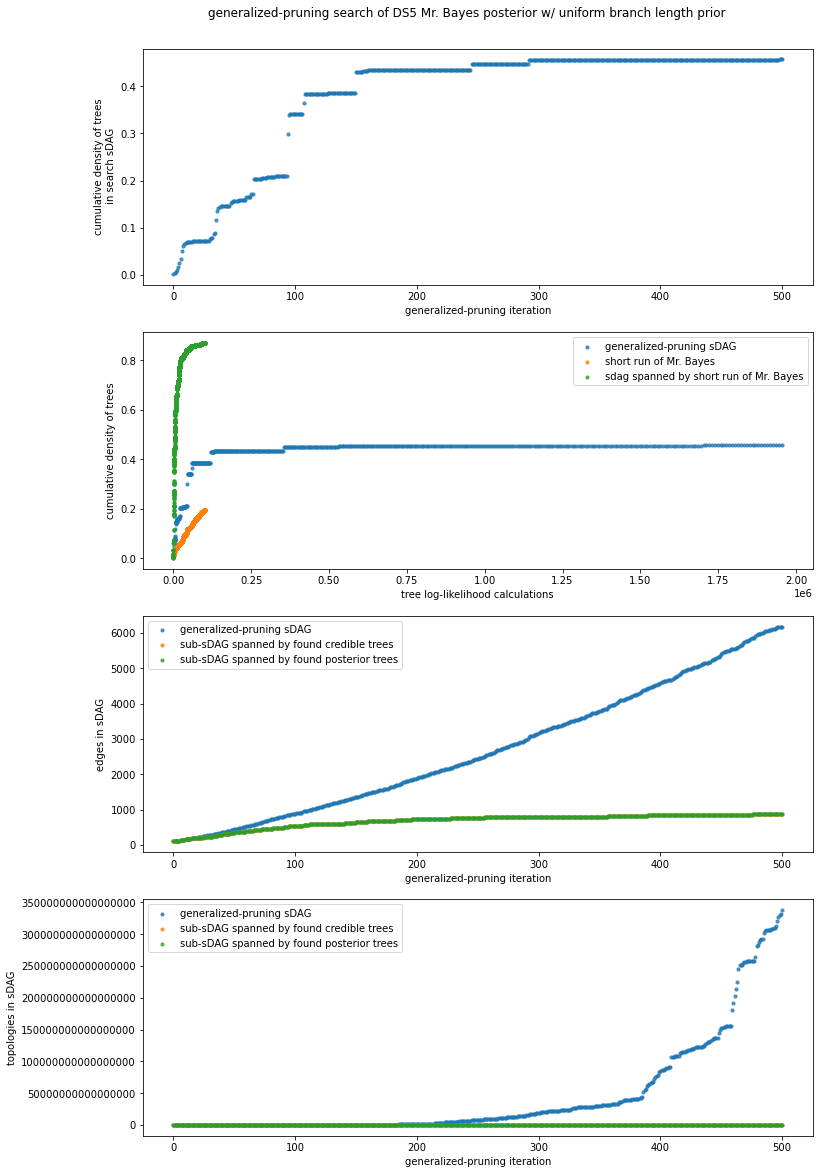

In [44]:
plot_search_results(5, "uniform", "generalized-pruning")

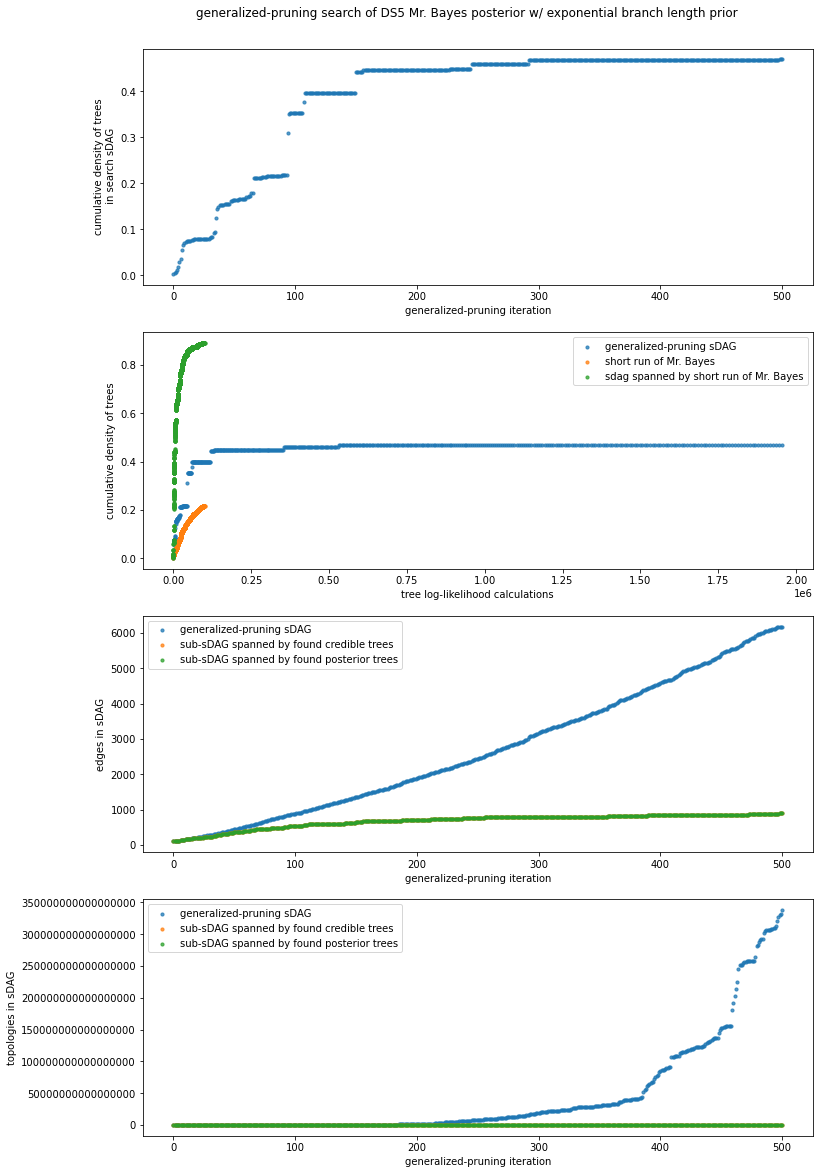

In [43]:
plot_search_results(5, "exponential", "generalized-pruning")

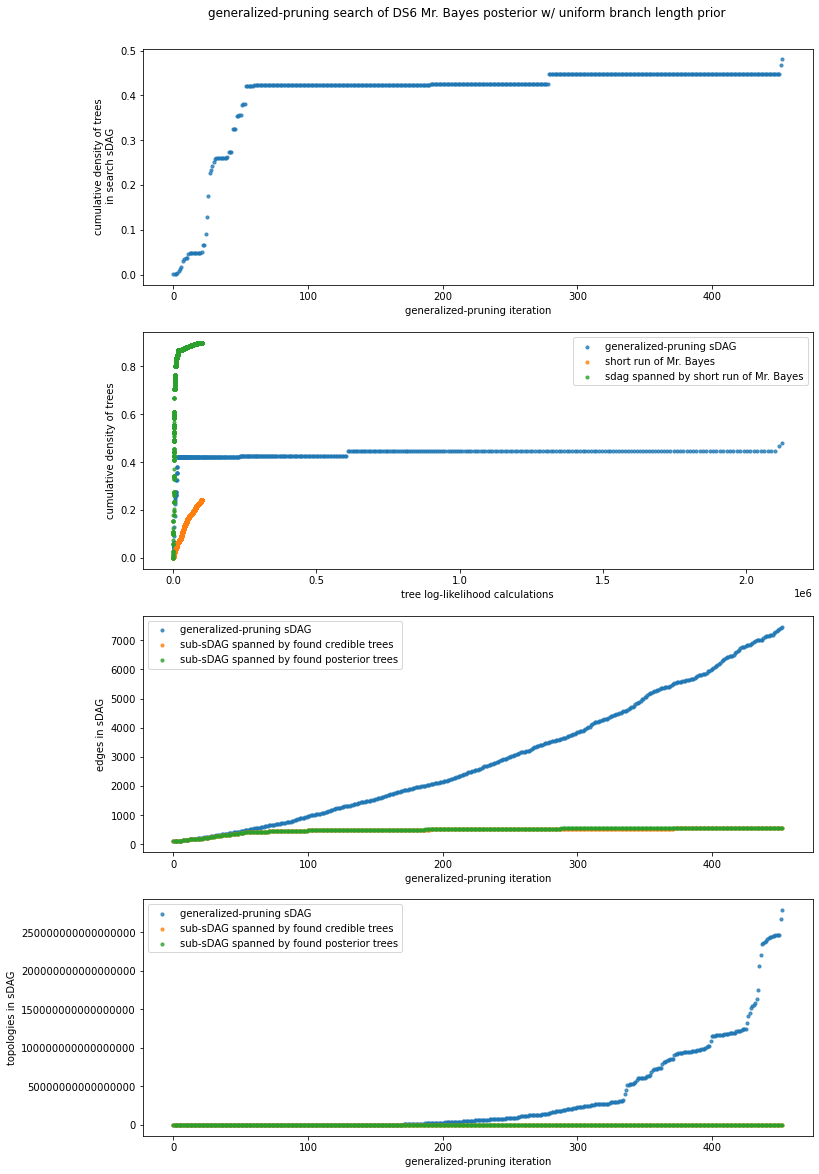

In [6]:
plot_search_results(6, "uniform", "generalized-pruning")

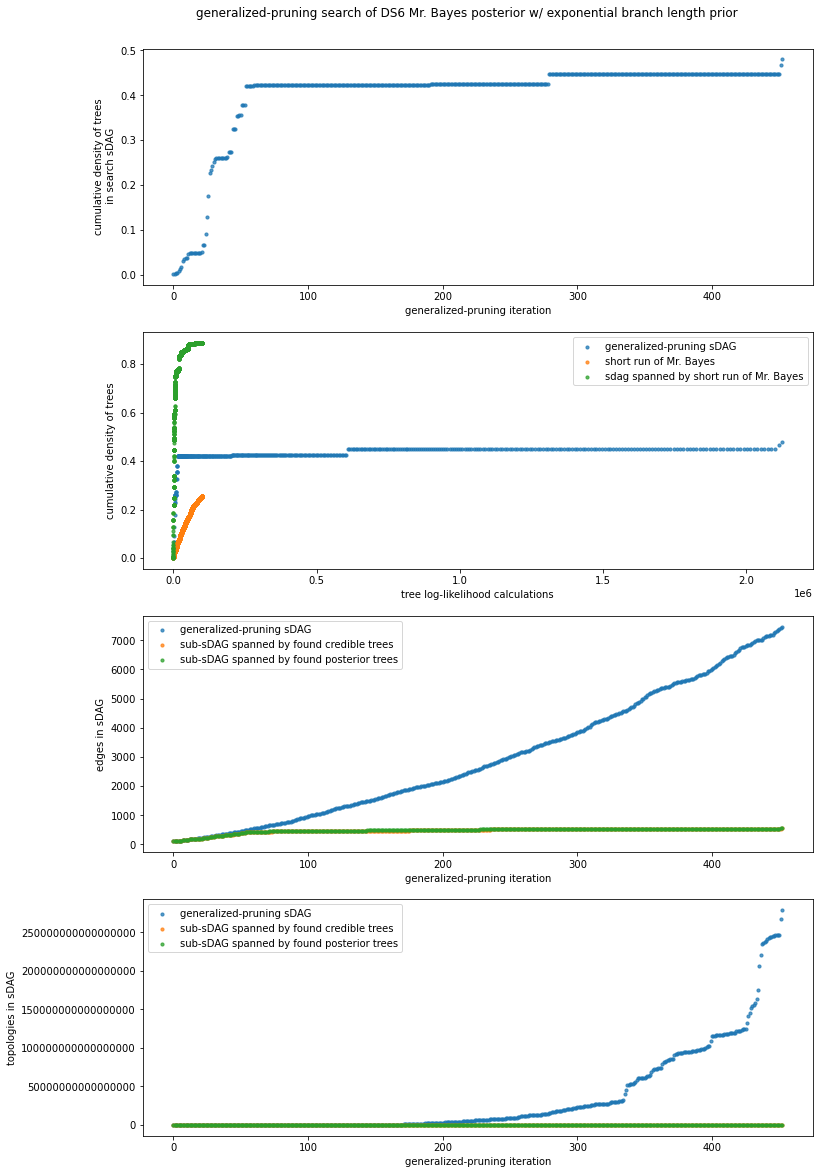

In [5]:
plot_search_results(6, "exponential", "generalized-pruning")

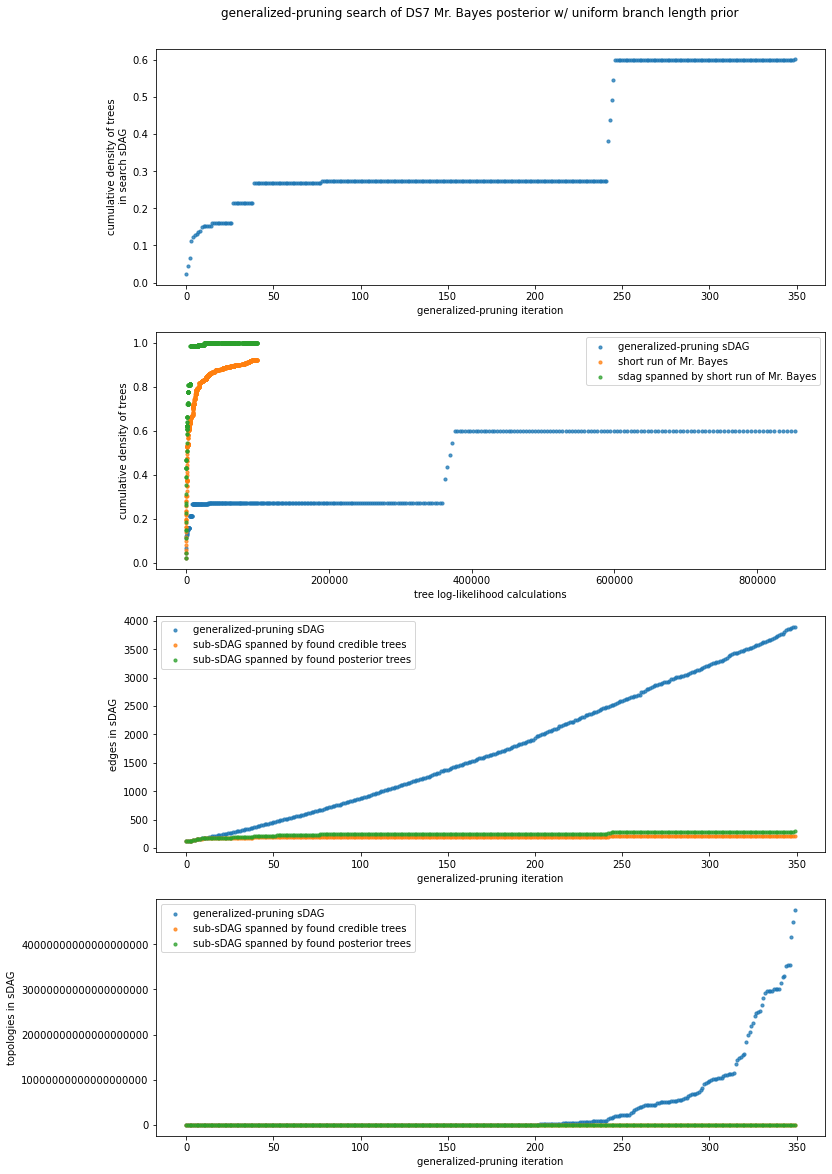

In [26]:
plot_search_results(7, "uniform", "generalized-pruning")

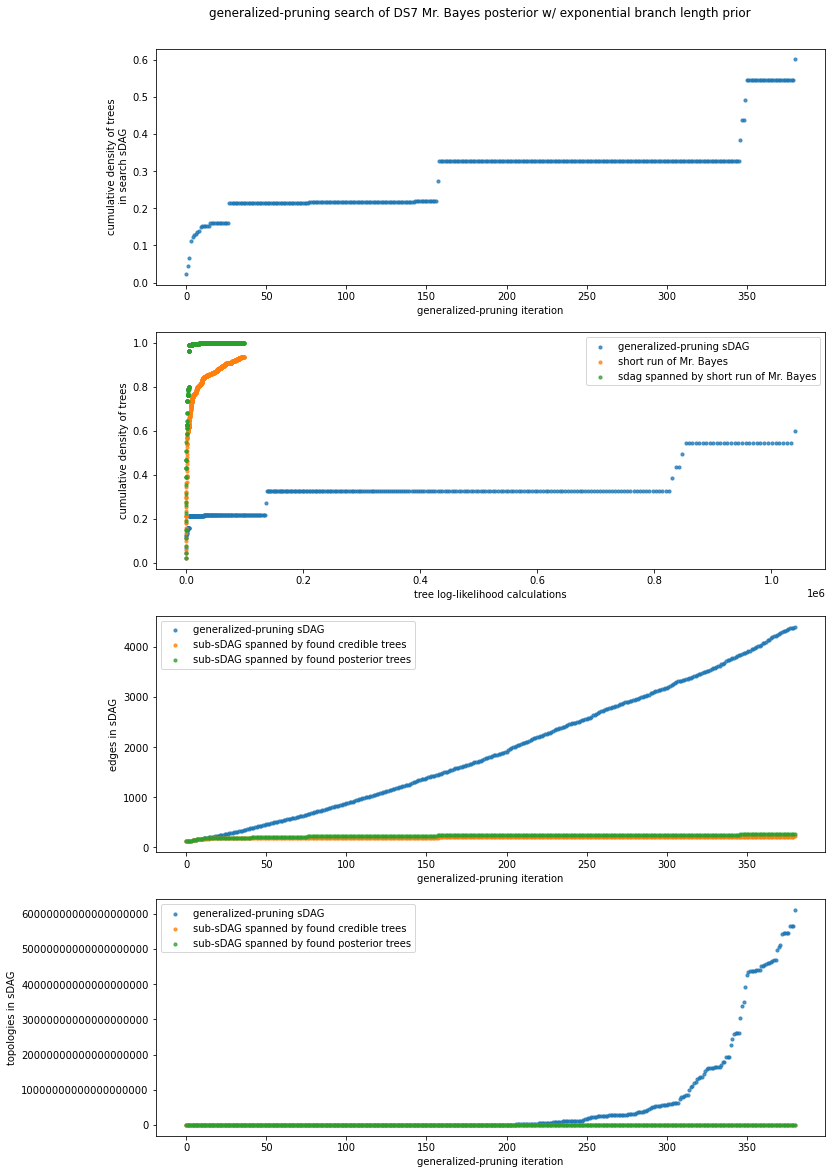

In [25]:
plot_search_results(7, "exponential", "generalized-pruning")

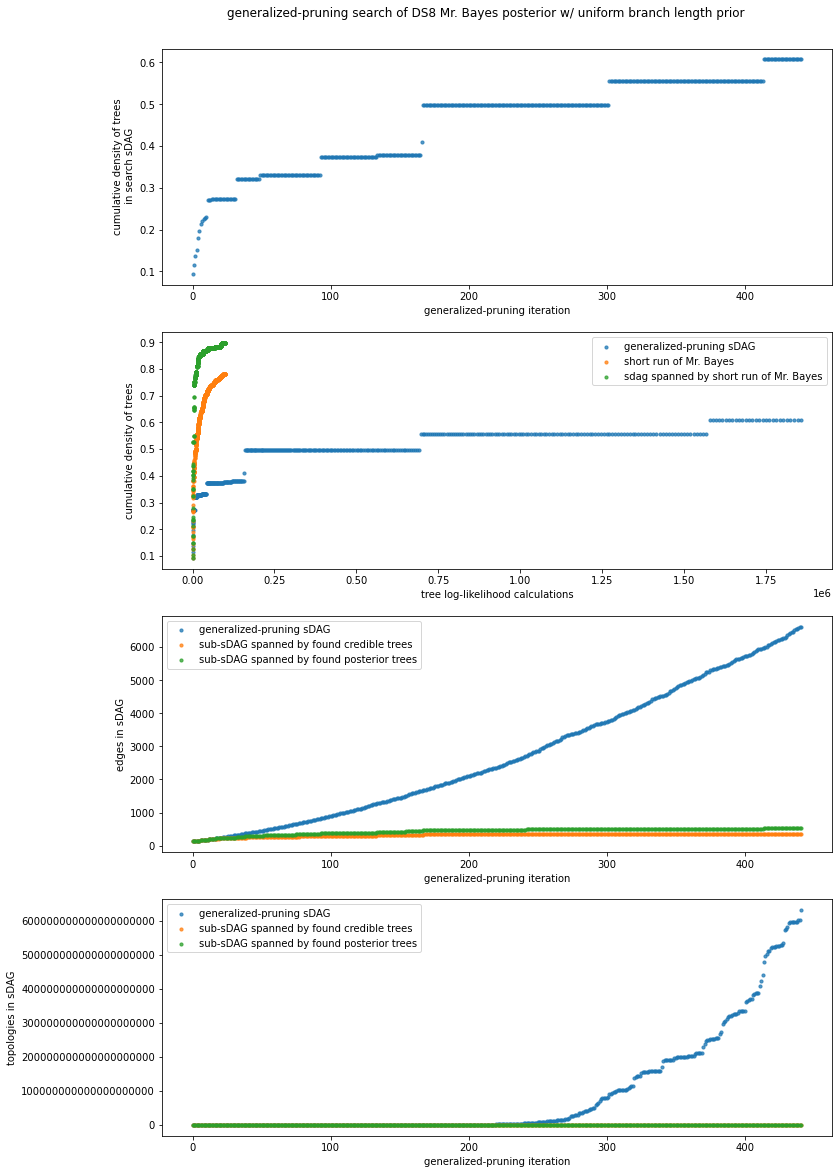

In [52]:
plot_search_results(8, "uniform", "generalized-pruning")

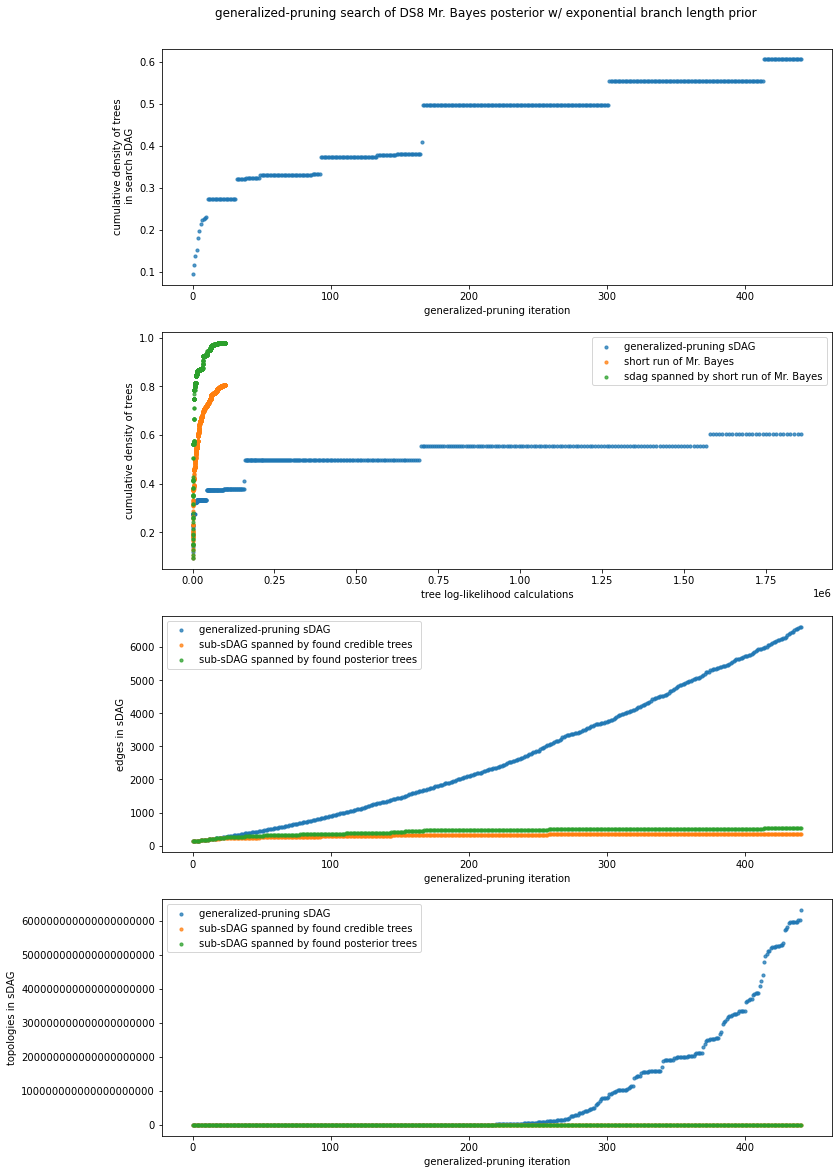

In [53]:
plot_search_results(8, "exponential", "generalized-pruning")